In [1]:
import pandas as pd
import numpy as np
from pandas.core import resample
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline


tf.reset_default_graph()
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 800)
pd.set_option('display.max_columns', 800)


def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        xset = []
        for j in range(dataset.shape[1]):
            a = dataset[i:(i+look_back), j]
            xset.append(a)
        dataY.append(dataset[i + look_back, ])      
        dataX.append(xset)
    return np.array(dataX), np.array(dataY)

In [2]:
from keras.models import load_model

#model.reset_states()
model = load_model("level12_model.h5")
#model = load_model("modelGBPJPY4H.h5")


import pickle
scaler = pickle.load(open('level12_model.pkl', 'rb'))
#scaler = pickle.load(open('modelGBPJPY4H.pkl', 'rb'))

Using TensorFlow backend.


In [3]:
# 為替予測

input_output_columns = 5
look_back=8                # model の設定と同じに
#number_of_historydata = 40



filename = '~/Documents/tensorflow/csv/LEVEL12.csv'

#ファイルを読み込む
df_csv = pd.read_csv(filename,
#                nrows=100000,
                usecols=['Date','Week',
                        'Open','High','Low','Close','Volume','Profit','HighLowDiff','OpenRelativePosition','CloseRelativePosition',
                        'RCIs','RCIm','RCIl','ADXdm','ADXdp','ADXadx','MACD','MACDsig'],
                dtype={ 'Date': str,
                        'Week':float,
                        'Open':float,'High':float,'Low':float,'Close':float,'Volume':float,'Profit':float,
                        'HighLowDiff':float,'OpenRelativePosition':float,'CloseRelativePosition':float,
                        'RCIs':float,'RCIm':float,'RCIl':float,'ADXdm':float,'ADXdp':float,'ADXadx':float,'MACD':float,'MACDsig':float},
                parse_dates=[0]
            ).sort_values(by='Date', ascending=True)

In [4]:
df_csv.index = df_csv['Date']
df = df_csv[df_csv.index.year>=2000]
df.sort_index(ascending=True)

df.dropna(inplace=True) #2つ以上のNanは削除。inplaceは自身を書き換え

In [5]:
dataframe = df.loc[:,['Open','High','Low','Close','ADXadx','HighLowDiff','OpenRelativePosition','CloseRelativePosition']].dropna()
#dataframe = dataframe[-number_of_historydata:] # 最後の方のデータを使う

In [6]:
# predict 用データをコピーし、float64へ。同じエリアへ scaler-fitする
dataset = dataframe.values
dataset = dataset.astype('float64')
dataset = scaler.transform(dataset)
dataset.shape

(720, 8)

In [7]:
print(dataframe[-5:])


                     Open  High  Low  Close  ADXadx  HighLowDiff  OpenRelativePosition  CloseRelativePosition
Date                                                                                                         
2010-06-18 04:00:00   5.0   5.0  5.0    5.0     5.0          5.0                   5.0                    5.0
2010-06-18 08:00:00   4.0   4.0  4.0    4.0     4.0          4.0                   4.0                    4.0
2010-06-18 12:00:00   3.0   3.0  3.0    3.0     3.0          3.0                   3.0                    3.0
2010-06-18 16:00:00   2.0   2.0  2.0    2.0     2.0          2.0                   2.0                    2.0
2010-06-18 20:00:00   1.0   1.0  1.0    1.0     1.0          1.0                   1.0                    1.0


In [8]:
#dataframe.info()

In [9]:
# LEVEL12 では使わない 
# HighLowDiff,OpenRelativePosition,CloseRelativePosition を再計算
#result_predicate_scaled[-1,5]=result_predicate_scaled[-1,1]-result_predicate_scaled[-1,2]
#result_predicate_scaled[-1,6]=((2*(result_predicate_scaled[-1,0]))-result_predicate_scaled[-1,1]-result_predicate_scaled[-1,2])/(result_predicate_scaled[-1,1]-(result_predicate_scaled[-1,2]))
#result_predicate_scaled[-1,7]=((2*(result_predicate_scaled[-1,3]))-result_predicate_scaled[-1,1]-result_predicate_scaled[-1,2])/(result_predicate_scaled[-1,1]-(result_predicate_scaled[-1,2]))
#print(result_predicate_scaled[-1:])

------ 過去のデータを抽出 datasetは既に標準値化済み ------
(20, 8)


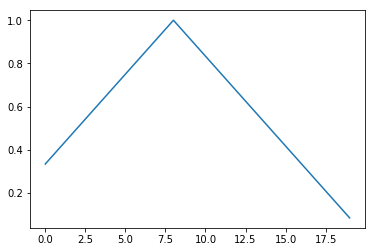

In [10]:
input_bars_for_predicate = 20  #　この先何本分を予測するか。

print('------ 過去のデータを抽出 datasetは既に標準値化済み ------')
dataset_input = dataset[input_bars_for_predicate*-1:]
print(dataset_input.shape)


future_result = np.empty((0,len(dataset_input[0])))
#print(future_result.shape)

plt.plot(dataset_input[-input_bars_for_predicate:,0])
plt.show()


In [11]:


for i in range(0,input_bars_for_predicate):

    dataset_tmp,dataset_nouse = create_dataset(dataset_input,look_back)
    predict_tmp = model.predict(dataset_tmp) #,batch_size=1,steps=None)
    
    print('')
    print('------ 予測のために与える値(標準値化後) ------')
    print(dataset_input.shape)
    print(dataset_input[-5:,0])

    print('------ 予測値(標準値) ------')
    print(predict_tmp.shape)
    print(predict_tmp[-5:,0])
    result_for_scale = np.hstack([predict_tmp, np.zeros([predict_tmp.shape[0],len(dataset_input[0])-input_output_columns ])]) #右へN列0追加
    print(result_for_scale.shape)

    # 予測値をデータとしていれられるよう、足らない右Ｎ（3列）を作る。 0列目と同じ値（行は同じ数字になるはず）
    result_for_scale[-1,5] = result_for_scale[-1,0] 
    result_for_scale[-1,6] = result_for_scale[-1,0] 
    result_for_scale[-1,7] = result_for_scale[-1,0] 

    # 次の予測のための準備：先頭を消し
    dataset_input = np.delete(dataset_input,0,axis=0)
    # 次の予測のための準備：末尾に予測値をセット
    dataset_input = np.vstack((dataset_input,result_for_scale[-1]))





------ 予測のために与える値(標準値化後) ------
(20, 8)
[0.41666667 0.33333333 0.25       0.16666667 0.08333333]
------ 予測値(標準値) ------
(11, 5)
[0.5034935  0.42326465 0.33913118 0.25595397 0.1745075 ]
(11, 8)

------ 予測のために与える値(標準値化後) ------
(20, 8)
[0.33333333 0.25       0.16666667 0.08333333 0.1745075 ]
------ 予測値(標準値) ------
(11, 5)
[0.42326465 0.33913118 0.25595397 0.1745075  0.09490523]
(11, 8)

------ 予測のために与える値(標準値化後) ------
(20, 8)
[0.25       0.16666667 0.08333333 0.1745075  0.09490523]
------ 予測値(標準値) ------
(11, 5)
[0.33913118 0.2559539  0.1745075  0.09490523 0.        ]
(11, 8)

------ 予測のために与える値(標準値化後) ------
(20, 8)
[0.16666667 0.08333333 0.1745075  0.09490523 0.        ]
------ 予測値(標準値) ------
(11, 5)
[0.2559539  0.1745075  0.09490523 0.         0.1067369 ]
(11, 8)

------ 予測のために与える値(標準値化後) ------
(20, 8)
[0.08333333 0.1745075  0.09490523 0.         0.1067369 ]
------ 予測値(標準値) ------
(11, 5)
[0.1745075  0.09490529 0.         0.1067369  0.17148477]
(11, 8)

------ 予測のために与える値(標準値化後) ----

 予測値から予測したデータ → これが全く形が似ない!!!


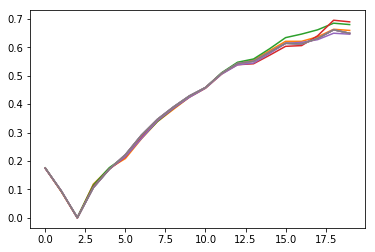

 40件の過去データ＋20件の予測値から予測したデータ


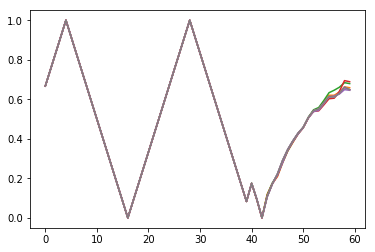

In [12]:

# plot用に過去データ＋予測値（20本）を追加して　invert    
last_result_scale = dataset_input[input_bars_for_predicate*-1:,]
concat_dataset = np.vstack((dataset,last_result_scale))
last_result = scaler.inverse_transform(concat_dataset)


print(' 予測値から予測したデータ → これが全く形が似ない!!!')

plt.plot(dataset_input)
#plt.plot(concat_dataset[-50:])
plt.show()

print(' 40件の過去データ＋20件の予測値から予測したデータ')
#plt.plot(dataset_input)
plt.plot(concat_dataset[-60:])
plt.show()

